# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:05<00:00, 10.0KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

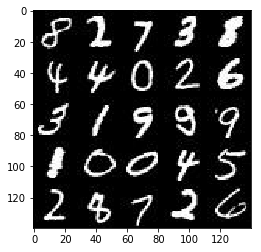

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

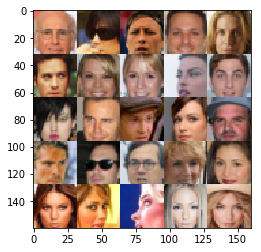

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 32, 32, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [124]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs_ = tf.placeholder(tf.float32,[None,image_width,image_height,image_channels],name='real_inputs')
    z_inputs_ = tf.placeholder(tf.float32,[None,z_dim],name='z_inputs')
    learning_rate = tf.placeholder(tf.float32)
    return (real_inputs_,z_inputs_,learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/jim/anaconda3/envs/gym35/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/jim/anaconda3/envs/gym35/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/jim/anaconda3/envs/gym35/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/jim/anaconda3/envs/gym35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/jim/anaconda3/envs/gym35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/jim/anaconda3/envs

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [362]:
#i'm using the discriminator architecture from the Deep Convolution GAN lesson

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator",reuse=reuse):
        alpha = 0.2
        # Input layer is 28x28x3
        #print(images.shape)
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=1, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1.shape)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2.shape)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3.shape)
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        #print(relu4.shape)
        
#         x5 = tf.layers.conv2d(relu4, 1024, 5, strides=2, padding='same')
#         bn5 = tf.layers.batch_normalization(x5, training=True)
#         relu5 = tf.maximum(alpha * bn5, bn5)
#         #print(relu5.shape)
       
        # Flatten it
        flat = tf.reshape(relu4, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        #print(out.shape,logits.shape)

        return (out,logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


In [ ]:
# (?, 7, 7, 512)
# (?, 14, 14, 256)
# (?, 14, 14, 128)
# (?, 28, 28, 64)
# (?, 28, 28, 5)

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [364]:
#using the generator shape from the DC GAN lesson

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope("generator",reuse= not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.shape)
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.shape)
        x3 = tf.layers.conv2d_transpose(x2,128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape)
        x4 = tf.layers.conv2d_transpose(x3,64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        #print(x4.shape)
#         x5 = tf.layers.conv2d_transpose(x4,64, 5, strides=1, padding='valid')
#         x5 = tf.layers.batch_normalization(x5, training=is_train)
#         x5 = tf.maximum(alpha * x5, x5)
#         print(x5.shape)
#         x6 = tf.layers.conv2d_transpose(x5,32, 5, strides=1, padding='valid')
#         x6 = tf.layers.batch_normalization(x6, training=is_train)
#         x6 = tf.maximum(alpha * x6, x6)
#         print(x6.shape)
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        #print(logits.shape)
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [365]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim,is_train=True)
    d_model_real, d_logits_real = discriminator(input_real,reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True)
    
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
#     d_loss_real = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss,g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [366]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [367]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [368]:
# mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
# print(mnist_dataset.shape, mnist_dataset.image_mode)
# print(mnist_dataset.shape[3])
# print(mnist_dataset.get_batches(128))

In [369]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real,input_z, l_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_real,input_z,data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss,g_loss,l_rate,beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2 #forums say that due to tanh, need to make range -1 to 1
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real:  batch_images, input_z: batch_z, 
                                                     l_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images,
                                                    l_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images,
                                                    l_rate:learning_rate})
#                 _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images,
#                                                     l_rate:learning_rate})
#                 _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images,
#                                     l_rate:learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))
                if steps % 100 == 0:    
                    show_generator_output(sess,25,input_z,data_shape[3],data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.0483... Generator Loss: 1.5814
Epoch 1/2... Discriminator Loss: 3.0039... Generator Loss: 0.4645
Epoch 1/2... Discriminator Loss: 3.3002... Generator Loss: 0.0927
Epoch 1/2... Discriminator Loss: 2.3488... Generator Loss: 0.2518
Epoch 1/2... Discriminator Loss: 1.8731... Generator Loss: 0.3969
Epoch 1/2... Discriminator Loss: 1.6883... Generator Loss: 0.5852
Epoch 1/2... Discriminator Loss: 1.9491... Generator Loss: 2.4950
Epoch 1/2... Discriminator Loss: 1.8215... Generator Loss: 0.3735
Epoch 1/2... Discriminator Loss: 1.5213... Generator Loss: 0.8371
Epoch 1/2... Discriminator Loss: 1.3694... Generator Loss: 0.7903


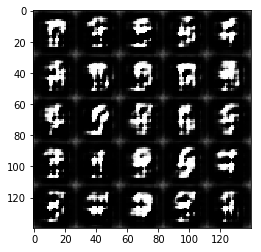

Epoch 1/2... Discriminator Loss: 1.8679... Generator Loss: 1.3257
Epoch 1/2... Discriminator Loss: 1.3286... Generator Loss: 1.6848
Epoch 1/2... Discriminator Loss: 1.9983... Generator Loss: 1.4271
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 1.0244
Epoch 1/2... Discriminator Loss: 1.2081... Generator Loss: 0.9613
Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 0.7147
Epoch 1/2... Discriminator Loss: 2.1638... Generator Loss: 0.2273
Epoch 1/2... Discriminator Loss: 2.4364... Generator Loss: 0.1741
Epoch 1/2... Discriminator Loss: 2.0790... Generator Loss: 0.2615
Epoch 1/2... Discriminator Loss: 1.4177... Generator Loss: 0.6401


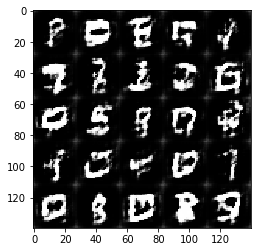

Epoch 1/2... Discriminator Loss: 2.4589... Generator Loss: 2.4993
Epoch 1/2... Discriminator Loss: 1.4062... Generator Loss: 0.8125
Epoch 1/2... Discriminator Loss: 1.6234... Generator Loss: 0.5673
Epoch 1/2... Discriminator Loss: 1.6568... Generator Loss: 0.6117
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 1.2089
Epoch 1/2... Discriminator Loss: 1.4362... Generator Loss: 0.5395
Epoch 1/2... Discriminator Loss: 1.2865... Generator Loss: 0.8037
Epoch 1/2... Discriminator Loss: 1.7062... Generator Loss: 0.4521
Epoch 1/2... Discriminator Loss: 1.5118... Generator Loss: 0.6426
Epoch 1/2... Discriminator Loss: 1.7265... Generator Loss: 1.2781


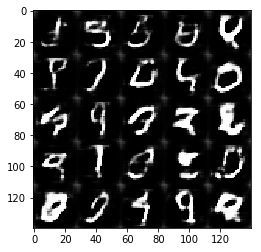

Epoch 1/2... Discriminator Loss: 2.0299... Generator Loss: 0.2992
Epoch 1/2... Discriminator Loss: 1.6035... Generator Loss: 1.2656
Epoch 1/2... Discriminator Loss: 1.9956... Generator Loss: 0.2650
Epoch 1/2... Discriminator Loss: 1.4052... Generator Loss: 0.8331
Epoch 1/2... Discriminator Loss: 1.4784... Generator Loss: 0.6143
Epoch 1/2... Discriminator Loss: 2.1624... Generator Loss: 2.1514
Epoch 1/2... Discriminator Loss: 1.6194... Generator Loss: 1.4251
Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 1.2076
Epoch 1/2... Discriminator Loss: 1.8168... Generator Loss: 0.9923
Epoch 1/2... Discriminator Loss: 1.5703... Generator Loss: 0.5446


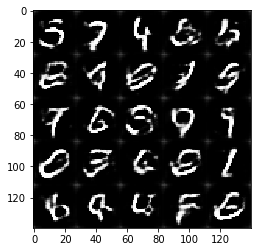

Epoch 1/2... Discriminator Loss: 1.6747... Generator Loss: 0.4669
Epoch 1/2... Discriminator Loss: 2.0332... Generator Loss: 0.3286
Epoch 1/2... Discriminator Loss: 1.3701... Generator Loss: 1.0833
Epoch 1/2... Discriminator Loss: 1.7846... Generator Loss: 0.5363
Epoch 1/2... Discriminator Loss: 1.7360... Generator Loss: 0.3148
Epoch 1/2... Discriminator Loss: 1.6140... Generator Loss: 0.4600
Epoch 2/2... Discriminator Loss: 1.6413... Generator Loss: 1.6888
Epoch 2/2... Discriminator Loss: 1.2158... Generator Loss: 1.2438
Epoch 2/2... Discriminator Loss: 1.5093... Generator Loss: 0.9928
Epoch 2/2... Discriminator Loss: 1.8128... Generator Loss: 0.3060


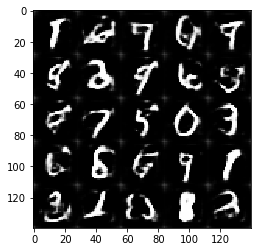

Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.6784
Epoch 2/2... Discriminator Loss: 1.3092... Generator Loss: 1.0107
Epoch 2/2... Discriminator Loss: 1.4715... Generator Loss: 0.7539
Epoch 2/2... Discriminator Loss: 1.2390... Generator Loss: 0.9678
Epoch 2/2... Discriminator Loss: 1.9950... Generator Loss: 2.0651
Epoch 2/2... Discriminator Loss: 1.4920... Generator Loss: 0.7558
Epoch 2/2... Discriminator Loss: 2.0149... Generator Loss: 0.3346
Epoch 2/2... Discriminator Loss: 2.4128... Generator Loss: 1.7189
Epoch 2/2... Discriminator Loss: 1.3101... Generator Loss: 1.0744
Epoch 2/2... Discriminator Loss: 1.1718... Generator Loss: 0.9425


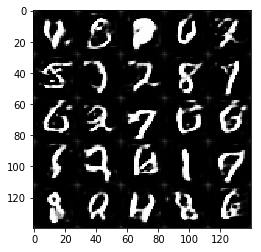

Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.8738
Epoch 2/2... Discriminator Loss: 1.7592... Generator Loss: 0.3525
Epoch 2/2... Discriminator Loss: 1.6753... Generator Loss: 0.3810
Epoch 2/2... Discriminator Loss: 1.4734... Generator Loss: 1.3750
Epoch 2/2... Discriminator Loss: 2.0231... Generator Loss: 0.2897
Epoch 2/2... Discriminator Loss: 1.6061... Generator Loss: 1.4641
Epoch 2/2... Discriminator Loss: 1.5965... Generator Loss: 0.7143
Epoch 2/2... Discriminator Loss: 2.1173... Generator Loss: 0.2747
Epoch 2/2... Discriminator Loss: 1.5192... Generator Loss: 0.4858
Epoch 2/2... Discriminator Loss: 1.3946... Generator Loss: 0.9277


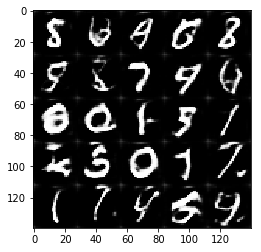

Epoch 2/2... Discriminator Loss: 1.6997... Generator Loss: 2.0274
Epoch 2/2... Discriminator Loss: 1.1542... Generator Loss: 1.0900
Epoch 2/2... Discriminator Loss: 1.6717... Generator Loss: 0.4287
Epoch 2/2... Discriminator Loss: 1.2923... Generator Loss: 0.7424
Epoch 2/2... Discriminator Loss: 1.6557... Generator Loss: 0.9931
Epoch 2/2... Discriminator Loss: 1.3608... Generator Loss: 1.4860
Epoch 2/2... Discriminator Loss: 1.7345... Generator Loss: 0.4077
Epoch 2/2... Discriminator Loss: 1.3453... Generator Loss: 0.8887
Epoch 2/2... Discriminator Loss: 2.7773... Generator Loss: 0.1313
Epoch 2/2... Discriminator Loss: 1.7638... Generator Loss: 0.5065


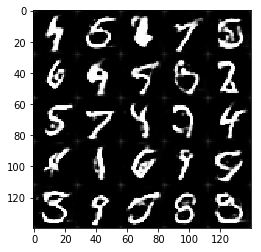

Epoch 2/2... Discriminator Loss: 1.3404... Generator Loss: 0.8579
Epoch 2/2... Discriminator Loss: 1.9341... Generator Loss: 1.7999
Epoch 2/2... Discriminator Loss: 1.2050... Generator Loss: 0.8667
Epoch 2/2... Discriminator Loss: 1.7037... Generator Loss: 0.3807
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.8126
Epoch 2/2... Discriminator Loss: 1.1836... Generator Loss: 0.8466
Epoch 2/2... Discriminator Loss: 1.7247... Generator Loss: 1.5509
Epoch 2/2... Discriminator Loss: 1.5312... Generator Loss: 0.5370
Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 1.1429
Epoch 2/2... Discriminator Loss: 1.3367... Generator Loss: 0.8416


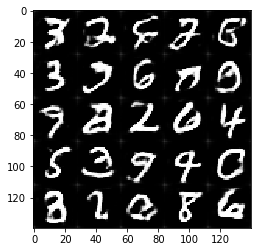

Epoch 2/2... Discriminator Loss: 1.6699... Generator Loss: 0.4999
Epoch 2/2... Discriminator Loss: 1.4834... Generator Loss: 0.7659
Epoch 2/2... Discriminator Loss: 1.4449... Generator Loss: 0.6552


In [346]:
batch_size = 128
z_dim = 102#84#100
learning_rate = 0.001#0.0007#0.0002
beta1 = 0.4#0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.8809... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 2.6306... Generator Loss: 1.7102
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 1.6984
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 1.2904
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 1.3228
Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 3.8773
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 1.8352
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 1.1230
Epoch 1/1... Discriminator Loss: 0.7701... Generator Loss: 1.2849
Epoch 1/1... Discriminator Loss: 0.5320... Generator Loss: 3.0089


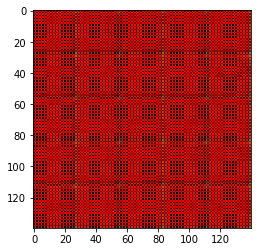

Epoch 1/1... Discriminator Loss: 0.5290... Generator Loss: 2.6563
Epoch 1/1... Discriminator Loss: 0.6281... Generator Loss: 3.3274
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 4.3819
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 1.6715
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.6023... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 2.0140
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.9268... Generator Loss: 0.3055


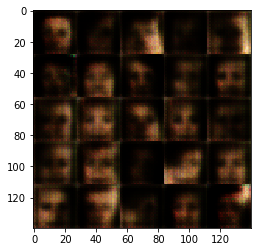

Epoch 1/1... Discriminator Loss: 2.5581... Generator Loss: 0.4262
Epoch 1/1... Discriminator Loss: 3.3781... Generator Loss: 4.6107
Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 2.1589
Epoch 1/1... Discriminator Loss: 0.5640... Generator Loss: 1.9175
Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 1.5255
Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 1.3557
Epoch 1/1... Discriminator Loss: 0.5505... Generator Loss: 2.1807
Epoch 1/1... Discriminator Loss: 0.6655... Generator Loss: 1.5946
Epoch 1/1... Discriminator Loss: 0.4377... Generator Loss: 3.6709
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 2.1014


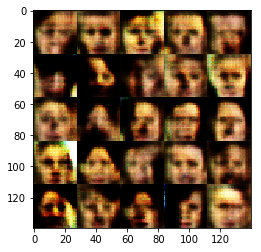

Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 1.4772
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 1.2387
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 1.1587
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 1.5591
Epoch 1/1... Discriminator Loss: 1.7355... Generator Loss: 2.5952
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 2.3009
Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 2.0886
Epoch 1/1... Discriminator Loss: 1.8539... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 0.7796... Generator Loss: 1.5179


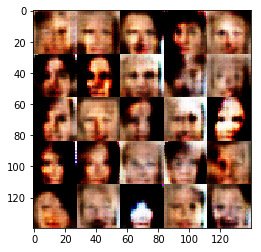

Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 2.1401
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 2.2898
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 4.7631
Epoch 1/1... Discriminator Loss: 0.4880... Generator Loss: 2.5391
Epoch 1/1... Discriminator Loss: 0.5530... Generator Loss: 4.2940
Epoch 1/1... Discriminator Loss: 2.0818... Generator Loss: 0.3326


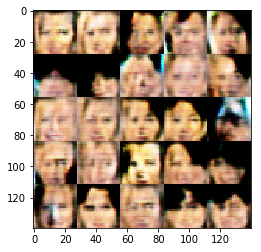

Epoch 1/1... Discriminator Loss: 2.1856... Generator Loss: 0.2300
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 2.6147
Epoch 1/1... Discriminator Loss: 2.8758... Generator Loss: 5.0058
Epoch 1/1... Discriminator Loss: 2.5385... Generator Loss: 0.1938
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 0.4515... Generator Loss: 2.4743
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 1.5850
Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 1.8227
Epoch 1/1... Discriminator Loss: 0.5305... Generator Loss: 2.2200
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.2554


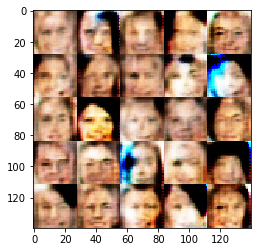

Epoch 1/1... Discriminator Loss: 0.3908... Generator Loss: 5.2134
Epoch 1/1... Discriminator Loss: 0.7870... Generator Loss: 1.7427
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 1.9518
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 1.4961
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 0.5342... Generator Loss: 4.4471
Epoch 1/1... Discriminator Loss: 2.6685... Generator Loss: 4.3670
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 1.7766
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 1.1517


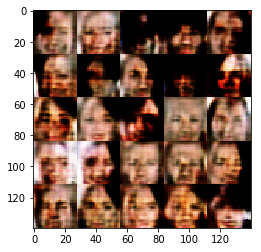

Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.5217
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 3.2683
Epoch 1/1... Discriminator Loss: 0.5803... Generator Loss: 1.8956
Epoch 1/1... Discriminator Loss: 0.4198... Generator Loss: 4.6116
Epoch 1/1... Discriminator Loss: 0.4053... Generator Loss: 4.0846
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 1.5535
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.2438
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.7024


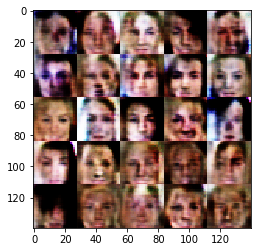

Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 1.4556
Epoch 1/1... Discriminator Loss: 1.7431... Generator Loss: 0.3999
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 0.6753... Generator Loss: 2.0132
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 1.1006
Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 1.5197
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 1.8610
Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 1.2280
Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 4.1888


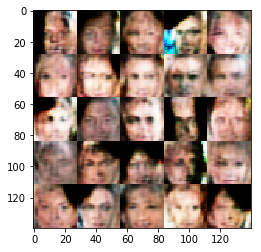

Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 1.4769
Epoch 1/1... Discriminator Loss: 1.5805... Generator Loss: 1.2987
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 3.0827... Generator Loss: 0.1069
Epoch 1/1... Discriminator Loss: 0.5279... Generator Loss: 2.7808
Epoch 1/1... Discriminator Loss: 4.2363... Generator Loss: 0.0366
Epoch 1/1... Discriminator Loss: 2.2252... Generator Loss: 0.2334
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 1.4535
Epoch 1/1... Discriminator Loss: 0.8156... Generator Loss: 1.3674


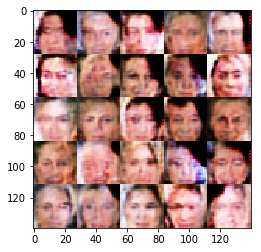

Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 2.2014
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 1.1849
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.9839
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 2.5731
Epoch 1/1... Discriminator Loss: 0.4484... Generator Loss: 2.9506
Epoch 1/1... Discriminator Loss: 2.6924... Generator Loss: 4.4770


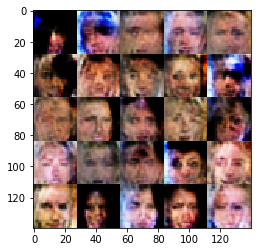

Epoch 1/1... Discriminator Loss: 0.6753... Generator Loss: 2.2981
Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.5503
Epoch 1/1... Discriminator Loss: 0.4239... Generator Loss: 3.9513
Epoch 1/1... Discriminator Loss: 1.9975... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 1.2587
Epoch 1/1... Discriminator Loss: 1.8579... Generator Loss: 0.3002
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 1.2309
Epoch 1/1... Discriminator Loss: 2.2001... Generator Loss: 0.2410


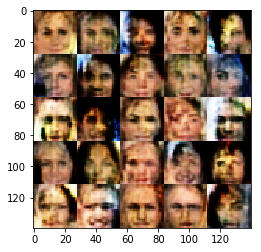

Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 1.5471
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 0.7694... Generator Loss: 1.8357
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 1.2197
Epoch 1/1... Discriminator Loss: 2.3884... Generator Loss: 0.1792
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 1.2649
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.9632
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 2.0836
Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 1.4974


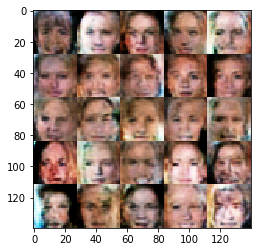

Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 1.4608
Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 1.2379
Epoch 1/1... Discriminator Loss: 0.5912... Generator Loss: 2.7047
Epoch 1/1... Discriminator Loss: 1.6380... Generator Loss: 1.5317
Epoch 1/1... Discriminator Loss: 1.5808... Generator Loss: 0.4400
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 2.7695... Generator Loss: 0.1813
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 1.5374


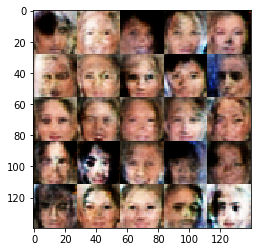

Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 0.7981... Generator Loss: 1.5685
Epoch 1/1... Discriminator Loss: 0.5493... Generator Loss: 2.1570
Epoch 1/1... Discriminator Loss: 0.8166... Generator Loss: 1.5316
Epoch 1/1... Discriminator Loss: 0.5359... Generator Loss: 2.4151
Epoch 1/1... Discriminator Loss: 2.8594... Generator Loss: 4.6507
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 2.0074
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 0.7297... Generator Loss: 1.6059


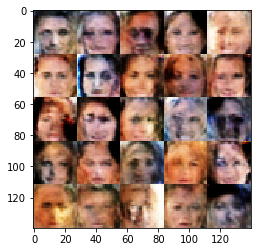

Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 2.8849
Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 1.7099
Epoch 1/1... Discriminator Loss: 0.4457... Generator Loss: 2.9514
Epoch 1/1... Discriminator Loss: 0.5427... Generator Loss: 2.1699
Epoch 1/1... Discriminator Loss: 0.4302... Generator Loss: 2.8868
Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 3.1988
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 1.4586
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 1.5200
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 1.7905


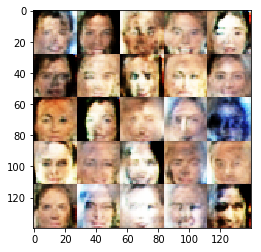

Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 1.5380
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.6264... Generator Loss: 2.5578
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 2.7013
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 1.5051
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.2366
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.4944


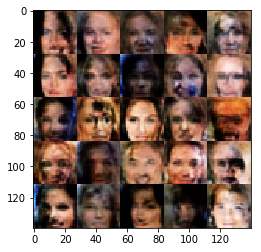

Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 1.6408
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.6269
Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 1.8714
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 0.7826... Generator Loss: 1.7534
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 2.4710
Epoch 1/1... Discriminator Loss: 0.7835... Generator Loss: 1.3053
Epoch 1/1... Discriminator Loss: 1.9705... Generator Loss: 2.4943
Epoch 1/1... Discriminator Loss: 0.6643... Generator Loss: 2.0040


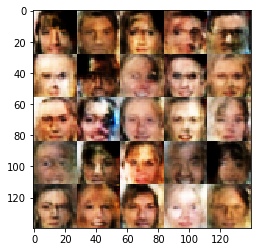

Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.7219... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 1.4047
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 1.8033
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 1.8048
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 1.7742


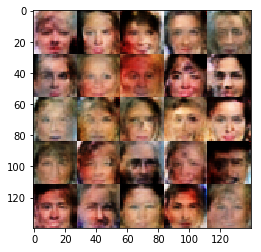

Epoch 1/1... Discriminator Loss: 0.8873... Generator Loss: 2.0188
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.9572
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 1.3009
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 3.1055
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 1.4788
Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 3.2278
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 1.2957
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 1.1641


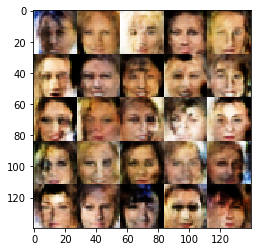

Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.9231
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.7065
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 1.7096... Generator Loss: 0.3621
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 1.4754
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 2.2962
Epoch 1/1... Discriminator Loss: 2.5657... Generator Loss: 3.6630
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.5890


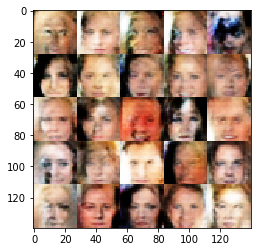

Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 1.5736
Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 1.4641
Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 0.5012
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 1.3137
Epoch 1/1... Discriminator Loss: 0.7651... Generator Loss: 1.5609
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.7880


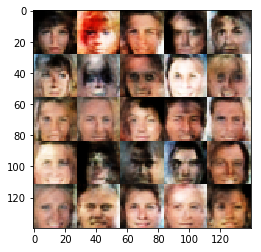

Epoch 1/1... Discriminator Loss: 0.6750... Generator Loss: 1.9113
Epoch 1/1... Discriminator Loss: 1.9105... Generator Loss: 0.2745
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 0.6289... Generator Loss: 2.5416
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.7430... Generator Loss: 3.3189
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 1.4252
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.3519
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 1.5528


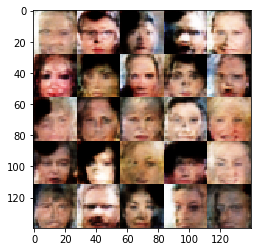

Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 4.7330
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 1.1830
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.2488
Epoch 1/1... Discriminator Loss: 0.4340... Generator Loss: 2.8092
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 1.5560
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.2559
Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 1.8800
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 2.0168
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.6234... Generator Loss: 0.4677


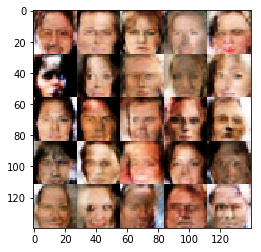

Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 1.5097
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 2.4496
Epoch 1/1... Discriminator Loss: 0.6272... Generator Loss: 1.6885
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 0.5333... Generator Loss: 2.4884
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.7634
Epoch 1/1... Discriminator Loss: 0.5809... Generator Loss: 2.3741
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 0.4123... Generator Loss: 3.4726


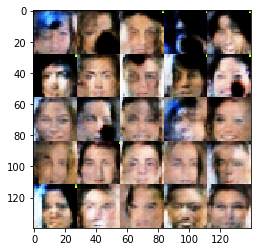

Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 2.0152
Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 4.0132
Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 3.7668
Epoch 1/1... Discriminator Loss: 3.9919... Generator Loss: 6.4646
Epoch 1/1... Discriminator Loss: 0.7100... Generator Loss: 1.9105
Epoch 1/1... Discriminator Loss: 0.5054... Generator Loss: 4.0172
Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 1.6578
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 1.5413
Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 1.2761
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 1.2450


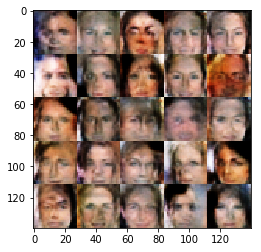

Epoch 1/1... Discriminator Loss: 1.6011... Generator Loss: 2.4539
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 2.4076
Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 2.3177
Epoch 1/1... Discriminator Loss: 1.6258... Generator Loss: 2.0093
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 2.9961
Epoch 1/1... Discriminator Loss: 0.7814... Generator Loss: 1.4017
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 1.1008
Epoch 1/1... Discriminator Loss: 1.5930... Generator Loss: 0.4815
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7497


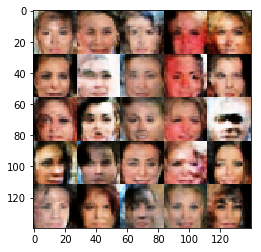

Epoch 1/1... Discriminator Loss: 0.6674... Generator Loss: 1.7263
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.6753... Generator Loss: 6.3696
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.8442... Generator Loss: 3.7643
Epoch 1/1... Discriminator Loss: 1.9284... Generator Loss: 0.3025
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.3280
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 1.6404
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 1.9674
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.3371


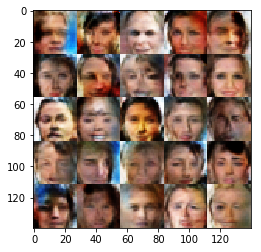

Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 2.3253
Epoch 1/1... Discriminator Loss: 2.3885... Generator Loss: 0.1864
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 2.6008
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.6631
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.2956
Epoch 1/1... Discriminator Loss: 1.6246... Generator Loss: 0.3867
Epoch 1/1... Discriminator Loss: 0.7509... Generator Loss: 1.6940
Epoch 1/1... Discriminator Loss: 1.6374... Generator Loss: 0.5027


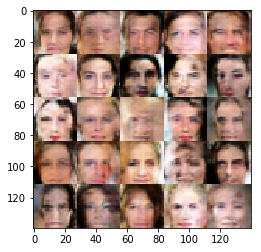

Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 2.0879... Generator Loss: 0.2525
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 2.4194
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 2.3783
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 1.2257
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.6981... Generator Loss: 0.4209
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.5146
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 0.7590... Generator Loss: 2.9946


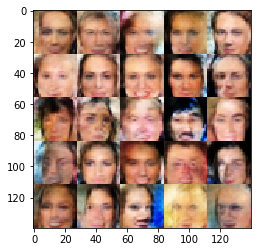

Epoch 1/1... Discriminator Loss: 3.1242... Generator Loss: 5.1362
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.3971
Epoch 1/1... Discriminator Loss: 0.5062... Generator Loss: 4.1325
Epoch 1/1... Discriminator Loss: 0.9345... Generator Loss: 2.6118
Epoch 1/1... Discriminator Loss: 0.5519... Generator Loss: 2.6335
Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 1.3493
Epoch 1/1... Discriminator Loss: 0.8729... Generator Loss: 1.4889
Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 2.8958
Epoch 1/1... Discriminator Loss: 1.0993... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 3.2013


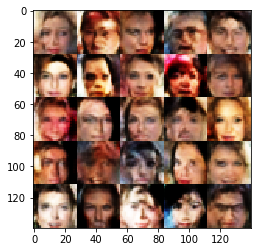

Epoch 1/1... Discriminator Loss: 0.5961... Generator Loss: 1.8475
Epoch 1/1... Discriminator Loss: 1.6725... Generator Loss: 0.4808
Epoch 1/1... Discriminator Loss: 2.2877... Generator Loss: 0.2018
Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 1.2823
Epoch 1/1... Discriminator Loss: 2.0362... Generator Loss: 0.2933
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 1.5138
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 3.3126
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 1.5539
Epoch 1/1... Discriminator Loss: 0.6188... Generator Loss: 1.8478


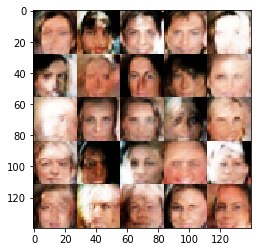

Epoch 1/1... Discriminator Loss: 2.8384... Generator Loss: 5.0231
Epoch 1/1... Discriminator Loss: 2.6005... Generator Loss: 4.2967
Epoch 1/1... Discriminator Loss: 0.5625... Generator Loss: 3.6784
Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 3.8362
Epoch 1/1... Discriminator Loss: 0.7375... Generator Loss: 1.7023
Epoch 1/1... Discriminator Loss: 0.3714... Generator Loss: 4.1800
Epoch 1/1... Discriminator Loss: 0.5712... Generator Loss: 2.4511
Epoch 1/1... Discriminator Loss: 0.5594... Generator Loss: 2.2561
Epoch 1/1... Discriminator Loss: 1.9731... Generator Loss: 6.5924
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.1201


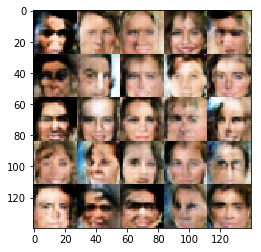

Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 0.4829... Generator Loss: 2.9647
Epoch 1/1... Discriminator Loss: 0.7365... Generator Loss: 1.4084
Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 2.4837
Epoch 1/1... Discriminator Loss: 2.7086... Generator Loss: 5.2022
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 2.0813
Epoch 1/1... Discriminator Loss: 1.6931... Generator Loss: 3.0280
Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 1.9420
Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 1.2509
Epoch 1/1... Discriminator Loss: 0.7461... Generator Loss: 2.7644


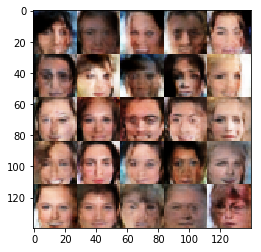

Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 2.3035
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 2.8904
Epoch 1/1... Discriminator Loss: 0.5122... Generator Loss: 2.8653
Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 1.7080
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 1.1348
Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 2.4089
Epoch 1/1... Discriminator Loss: 0.6491... Generator Loss: 2.0201
Epoch 1/1... Discriminator Loss: 0.4436... Generator Loss: 2.9630


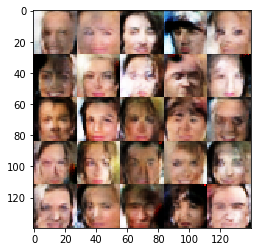

Epoch 1/1... Discriminator Loss: 0.4641... Generator Loss: 2.5204
Epoch 1/1... Discriminator Loss: 1.9234... Generator Loss: 0.3372
Epoch 1/1... Discriminator Loss: 0.7659... Generator Loss: 1.2887
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 4.1778
Epoch 1/1... Discriminator Loss: 0.6006... Generator Loss: 2.9719
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 0.7017... Generator Loss: 1.6336
Epoch 1/1... Discriminator Loss: 0.6756... Generator Loss: 1.8851
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 0.8681


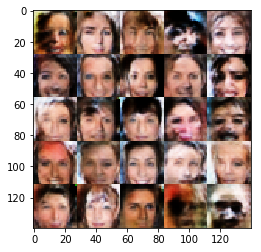

Epoch 1/1... Discriminator Loss: 0.7428... Generator Loss: 1.5121
Epoch 1/1... Discriminator Loss: 0.6391... Generator Loss: 1.7751
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 1.2007
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 4.1823
Epoch 1/1... Discriminator Loss: 0.6444... Generator Loss: 1.6683
Epoch 1/1... Discriminator Loss: 0.4825... Generator Loss: 2.1916
Epoch 1/1... Discriminator Loss: 0.5766... Generator Loss: 1.9795
Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 1.9202
Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 1.6144
Epoch 1/1... Discriminator Loss: 0.4139... Generator Loss: 3.6524


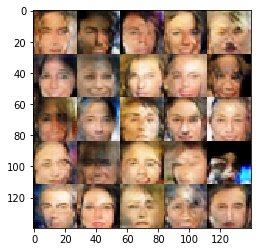

Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 2.2913
Epoch 1/1... Discriminator Loss: 0.5894... Generator Loss: 2.2909
Epoch 1/1... Discriminator Loss: 0.4456... Generator Loss: 3.1716
Epoch 1/1... Discriminator Loss: 0.3945... Generator Loss: 4.7871
Epoch 1/1... Discriminator Loss: 0.5869... Generator Loss: 3.9881
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.2427
Epoch 1/1... Discriminator Loss: 0.7641... Generator Loss: 2.0369
Epoch 1/1... Discriminator Loss: 0.5093... Generator Loss: 2.2377
Epoch 1/1... Discriminator Loss: 0.6615... Generator Loss: 2.1516
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.4882


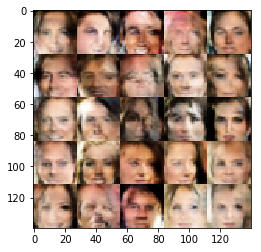

Epoch 1/1... Discriminator Loss: 0.5771... Generator Loss: 2.4565
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 0.5936... Generator Loss: 1.8601
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 0.7293... Generator Loss: 1.6663
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 2.1532
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 2.6197
Epoch 1/1... Discriminator Loss: 0.8150... Generator Loss: 1.3098
Epoch 1/1... Discriminator Loss: 0.4041... Generator Loss: 3.3446
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 2.6008


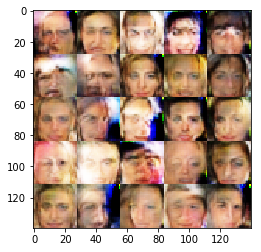

Epoch 1/1... Discriminator Loss: 0.4592... Generator Loss: 2.4225
Epoch 1/1... Discriminator Loss: 0.3628... Generator Loss: 3.9003
Epoch 1/1... Discriminator Loss: 0.4005... Generator Loss: 3.2695
Epoch 1/1... Discriminator Loss: 0.3778... Generator Loss: 4.1076
Epoch 1/1... Discriminator Loss: 0.3471... Generator Loss: 5.7948
Epoch 1/1... Discriminator Loss: 0.3677... Generator Loss: 3.9037
Epoch 1/1... Discriminator Loss: 0.4078... Generator Loss: 3.1685
Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 4.3192
Epoch 1/1... Discriminator Loss: 0.3666... Generator Loss: 4.4215
Epoch 1/1... Discriminator Loss: 0.7980... Generator Loss: 1.4596


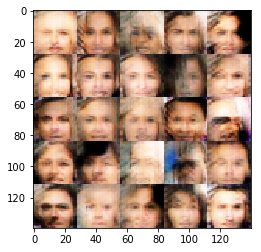

Epoch 1/1... Discriminator Loss: 0.5115... Generator Loss: 2.2195
Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 5.7760
Epoch 1/1... Discriminator Loss: 0.3624... Generator Loss: 5.4863
Epoch 1/1... Discriminator Loss: 0.3549... Generator Loss: 4.6474
Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 4.4299
Epoch 1/1... Discriminator Loss: 0.4259... Generator Loss: 4.0118
Epoch 1/1... Discriminator Loss: 0.4616... Generator Loss: 2.6130
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.1956
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 0.7390... Generator Loss: 1.4622


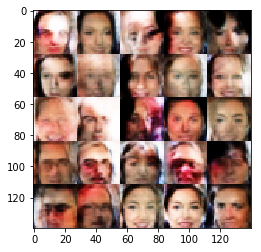

Epoch 1/1... Discriminator Loss: 0.7103... Generator Loss: 1.3406
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 3.9271
Epoch 1/1... Discriminator Loss: 0.3962... Generator Loss: 3.6469
Epoch 1/1... Discriminator Loss: 0.9273... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 0.7287... Generator Loss: 1.4075
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 1.5360
Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 1.5030
Epoch 1/1... Discriminator Loss: 1.8372... Generator Loss: 0.4038
Epoch 1/1... Discriminator Loss: 3.1054... Generator Loss: 0.1274
Epoch 1/1... Discriminator Loss: 1.7411... Generator Loss: 4.8764


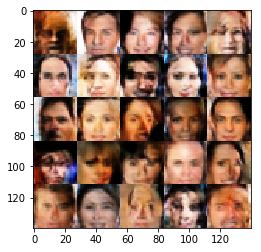

Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 1.5567
Epoch 1/1... Discriminator Loss: 0.5711... Generator Loss: 3.3390
Epoch 1/1... Discriminator Loss: 0.6104... Generator Loss: 2.3648
Epoch 1/1... Discriminator Loss: 0.4796... Generator Loss: 2.7210
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 2.2882
Epoch 1/1... Discriminator Loss: 0.6807... Generator Loss: 1.7632
Epoch 1/1... Discriminator Loss: 1.5533... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 1.2810
Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 2.3625
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.8355


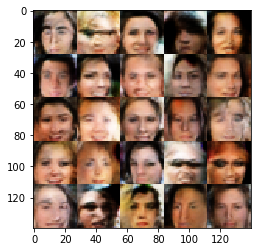

Epoch 1/1... Discriminator Loss: 0.7797... Generator Loss: 1.7652
Epoch 1/1... Discriminator Loss: 0.6370... Generator Loss: 1.5637
Epoch 1/1... Discriminator Loss: 0.9862... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 3.6309
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 1.9275
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.5831... Generator Loss: 0.5146
Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 1.2021
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 1.1253


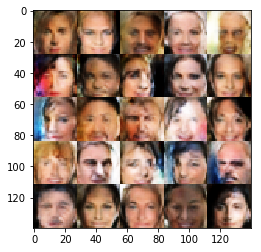

Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 1.1105
Epoch 1/1... Discriminator Loss: 2.5062... Generator Loss: 4.4857
Epoch 1/1... Discriminator Loss: 0.8363... Generator Loss: 2.9888
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 1.7397
Epoch 1/1... Discriminator Loss: 2.4354... Generator Loss: 5.7856
Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 1.9377
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 2.7711


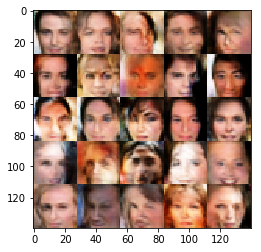

Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 1.6938
Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 2.1777
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 1.8399
Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 0.7363... Generator Loss: 3.6810
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 2.5522
Epoch 1/1... Discriminator Loss: 0.6577... Generator Loss: 1.6878
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 0.7994... Generator Loss: 2.7540
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 5.0582


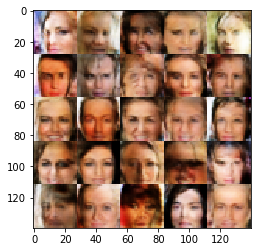

Epoch 1/1... Discriminator Loss: 0.4991... Generator Loss: 2.3988
Epoch 1/1... Discriminator Loss: 0.6058... Generator Loss: 2.3057
Epoch 1/1... Discriminator Loss: 0.5671... Generator Loss: 2.6086
Epoch 1/1... Discriminator Loss: 0.8389... Generator Loss: 3.4173
Epoch 1/1... Discriminator Loss: 4.3226... Generator Loss: 6.5145
Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 1.2979
Epoch 1/1... Discriminator Loss: 1.8900... Generator Loss: 0.3857
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.0230
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 1.2513


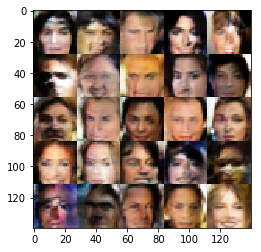

Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 3.0401
Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 1.9767
Epoch 1/1... Discriminator Loss: 0.7048... Generator Loss: 1.5568
Epoch 1/1... Discriminator Loss: 0.7694... Generator Loss: 1.2119
Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 1.1291
Epoch 1/1... Discriminator Loss: 0.6064... Generator Loss: 1.6653
Epoch 1/1... Discriminator Loss: 0.6705... Generator Loss: 1.6317
Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 1.4625
Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.7148


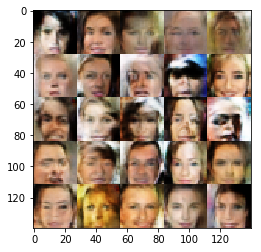

Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 1.3460
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.0761
Epoch 1/1... Discriminator Loss: 0.4775... Generator Loss: 2.7728
Epoch 1/1... Discriminator Loss: 0.7809... Generator Loss: 1.3446
Epoch 1/1... Discriminator Loss: 0.4625... Generator Loss: 2.9426
Epoch 1/1... Discriminator Loss: 0.4479... Generator Loss: 2.7185
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 3.7722
Epoch 1/1... Discriminator Loss: 0.5053... Generator Loss: 2.3820
Epoch 1/1... Discriminator Loss: 0.4134... Generator Loss: 3.5298


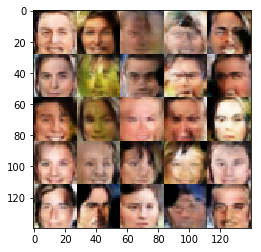

Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 1.4872
Epoch 1/1... Discriminator Loss: 0.8236... Generator Loss: 2.3929
Epoch 1/1... Discriminator Loss: 0.6282... Generator Loss: 1.7809
Epoch 1/1... Discriminator Loss: 0.5521... Generator Loss: 2.1465
Epoch 1/1... Discriminator Loss: 0.4025... Generator Loss: 3.5266
Epoch 1/1... Discriminator Loss: 0.4505... Generator Loss: 3.2082
Epoch 1/1... Discriminator Loss: 0.4187... Generator Loss: 3.1722
Epoch 1/1... Discriminator Loss: 0.6907... Generator Loss: 1.5633
Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.9553


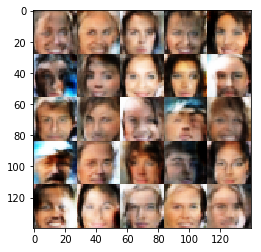

Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 2.0433
Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 1.1142
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 2.4566
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 3.2766
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 0.6687... Generator Loss: 1.5077
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.7954
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 2.7808


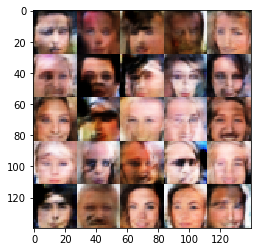

Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 3.7393
Epoch 1/1... Discriminator Loss: 2.5495... Generator Loss: 0.1944
Epoch 1/1... Discriminator Loss: 0.8854... Generator Loss: 1.2970
Epoch 1/1... Discriminator Loss: 0.4712... Generator Loss: 2.6124
Epoch 1/1... Discriminator Loss: 0.4818... Generator Loss: 2.4132
Epoch 1/1... Discriminator Loss: 0.6101... Generator Loss: 1.7180
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 1.7276
Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 1.2226
Epoch 1/1... Discriminator Loss: 0.4240... Generator Loss: 3.4510


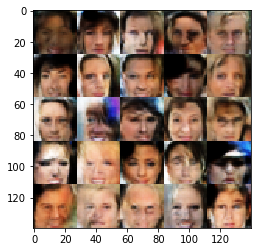

Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 2.0285
Epoch 1/1... Discriminator Loss: 0.8322... Generator Loss: 3.2990
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.3689
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 1.6694
Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 2.0199
Epoch 1/1... Discriminator Loss: 0.5267... Generator Loss: 2.6337


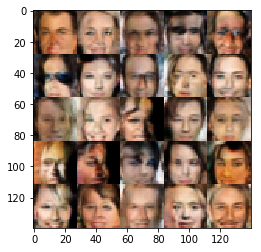

Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 1.2633
Epoch 1/1... Discriminator Loss: 0.4224... Generator Loss: 3.1313
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 2.3427
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 1.3027
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 5.2127
Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 1.8737
Epoch 1/1... Discriminator Loss: 0.7221... Generator Loss: 1.5194
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.3246


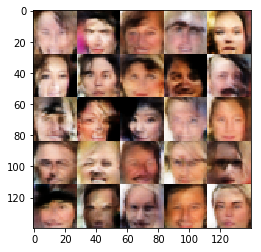

Epoch 1/1... Discriminator Loss: 0.5538... Generator Loss: 2.5600
Epoch 1/1... Discriminator Loss: 0.7342... Generator Loss: 1.4245
Epoch 1/1... Discriminator Loss: 0.6069... Generator Loss: 1.7666
Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 3.9420
Epoch 1/1... Discriminator Loss: 2.0458... Generator Loss: 5.4620
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 1.1961
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 2.4507
Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 4.0733
Epoch 1/1... Discriminator Loss: 0.6592... Generator Loss: 2.7830
Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 1.5500


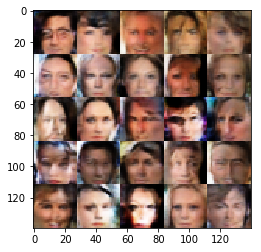

Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 3.1255
Epoch 1/1... Discriminator Loss: 1.6424... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 0.4599... Generator Loss: 2.6839
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 3.7699
Epoch 1/1... Discriminator Loss: 0.6933... Generator Loss: 1.5444
Epoch 1/1... Discriminator Loss: 0.4172... Generator Loss: 4.1411
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.2322
Epoch 1/1... Discriminator Loss: 0.4274... Generator Loss: 3.3939
Epoch 1/1... Discriminator Loss: 0.6445... Generator Loss: 1.5758
Epoch 1/1... Discriminator Loss: 0.4652... Generator Loss: 3.0731


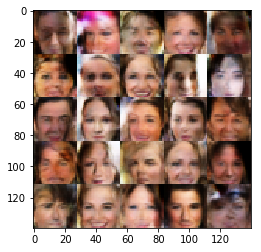

Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 1.1481
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 2.1011
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 3.0385
Epoch 1/1... Discriminator Loss: 2.0083... Generator Loss: 0.3469
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 0.6346... Generator Loss: 1.5691
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 0.4203... Generator Loss: 4.8657
Epoch 1/1... Discriminator Loss: 0.4546... Generator Loss: 2.5480


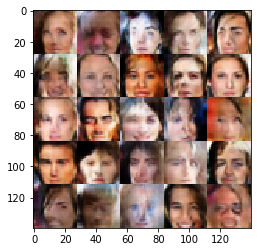

Epoch 1/1... Discriminator Loss: 0.5130... Generator Loss: 2.2866
Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 2.4640
Epoch 1/1... Discriminator Loss: 0.7400... Generator Loss: 1.6009
Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 2.0201
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 3.8404
Epoch 1/1... Discriminator Loss: 0.5842... Generator Loss: 3.9549
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 2.5463
Epoch 1/1... Discriminator Loss: 0.5014... Generator Loss: 3.6969
Epoch 1/1... Discriminator Loss: 0.3965... Generator Loss: 4.1756
Epoch 1/1... Discriminator Loss: 0.5750... Generator Loss: 1.8671


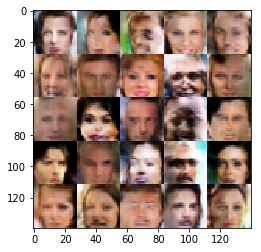

Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 2.2442
Epoch 1/1... Discriminator Loss: 0.6997... Generator Loss: 2.1068
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 4.7263
Epoch 1/1... Discriminator Loss: 0.5050... Generator Loss: 2.8001
Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 2.1317
Epoch 1/1... Discriminator Loss: 0.5078... Generator Loss: 3.7387
Epoch 1/1... Discriminator Loss: 0.5415... Generator Loss: 2.8930
Epoch 1/1... Discriminator Loss: 0.4471... Generator Loss: 2.8819
Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 4.7723


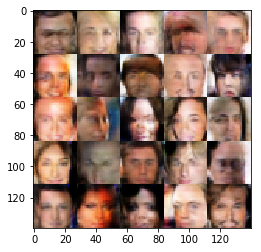

Epoch 1/1... Discriminator Loss: 0.4844... Generator Loss: 2.4222
Epoch 1/1... Discriminator Loss: 0.4021... Generator Loss: 3.4265
Epoch 1/1... Discriminator Loss: 0.5684... Generator Loss: 2.0710
Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 4.0261
Epoch 1/1... Discriminator Loss: 2.1120... Generator Loss: 0.4198
Epoch 1/1... Discriminator Loss: 0.6342... Generator Loss: 2.7181
Epoch 1/1... Discriminator Loss: 0.5447... Generator Loss: 1.9112
Epoch 1/1... Discriminator Loss: 0.3696... Generator Loss: 4.5527
Epoch 1/1... Discriminator Loss: 0.4104... Generator Loss: 3.0430
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 7.0248


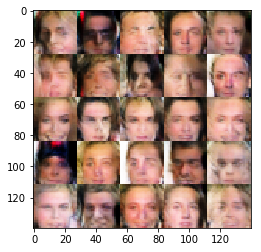

Epoch 1/1... Discriminator Loss: 0.3763... Generator Loss: 4.0673
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 1.4020
Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 2.2814
Epoch 1/1... Discriminator Loss: 0.7085... Generator Loss: 1.6580
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 2.2867
Epoch 1/1... Discriminator Loss: 1.8290... Generator Loss: 5.3551
Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 2.5807
Epoch 1/1... Discriminator Loss: 0.4701... Generator Loss: 4.3295
Epoch 1/1... Discriminator Loss: 0.5563... Generator Loss: 2.6946
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.5310


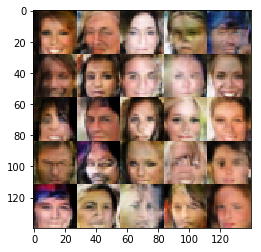

Epoch 1/1... Discriminator Loss: 1.5390... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 4.2709
Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 1.9163


KeyboardInterrupt: 

In [371]:
batch_size = 32 #64 #128
z_dim = 100 #102 #100 #56
learning_rate = 0.0004 #0.0007 #0.0008 #0.001 #0.01 #0.0009#0.0007#0.0002
beta1 = 0.35 #0.8 #0.5#0.45 #0.5

#64,100,0.0007,0.4, 1 generator run

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.